In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib

In [3]:
os.makedirs("gan_images", exist_ok=True)

In [4]:
directory = os.getcwd()
directory = directory + '\\cats_photos'

plt_width = plt_height = 8
matplotlib.rcParams['figure.figsize'] = [plt_width, plt_height]

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [5]:
def get_data_loader(data_dir=directory, width=64, height=64, batch_size=128, train = True):
    """
    Define the way we compose the batch dataset including the augmentation for increasing the number of data
    and return the augmented batch-dataset
    :param data_dir: root directory where the either train or test dataset is
    :param batch_size: size of the batch
    :param train: true if current phase is training, else false
    :return: augmented batch dataset
    """

    # define how we augment the data for composing the batch-dataset in train and test step
    transform = {
        'train': transforms.Compose([
            transforms.Resize([width, height]), # Resizing the image as the VGG only take 224 x 244 as input size
            #transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
            #transforms.LinearTransformation(transformation_matrix=)
        ]),
        'test': transforms.Compose([
            transforms.Resize([width, height]),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
    }

    # ImageFloder with root directory and defined transformation methods for batch as well as data augmentation
    data = torchvision.datasets.ImageFolder(root=data_dir, transform=transform['train'] if train else 'test')
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=4)

    return data_loader

In [6]:
def plot_images(images):
    if len(images) == 0:
        return
    
    color_map = ('rgb' if (len(images[0].shape) > 2) else 'gray')
    
    if len(images) == 2:
        image = images[0]
        reconstructed = images[1]
        if color_map == 'rgb':
            image = np.swapaxes(image, 0,1)
            image = np.swapaxes(image, 1,2)
            reconstructed = np.swapaxes(reconstructed, 0,1)
            reconstructed = np.swapaxes(reconstructed, 1,2)

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap=color_map)
        plt.title('Original')

        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed, cmap=color_map)
        plt.title('Reconstructed')
    
    else:
        for idx, image in enumerate(images):
            if color_map == 'rgb':
                image = np.swapaxes(image, 0,1)
                image = np.swapaxes(image, 1,2)
            plt.subplot(1, len(images), idx+1)
            plt.imshow(image, cmap=color_map)
            plt.title('Generated')
        
    plt.show()

In [7]:
class Generator(nn.Module):
    def __init__(self, hidden_size = 100):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(image_size * channels_size, hidden_size)
        self.fc_2 = nn.Linear(hidden_size, image_size * channels_size)
        self.relu = nn.LeakyReLU(negative_slope=0.05)
        self.drop = nn.Dropout(p=0.4)
        self.activation = nn.Sigmoid()
            
    def forward(self, x):
        x = x.view(batch_size, channels_size * image_size)
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.fc_2(x)
        x = self.activation(x)
        x = x.view(batch_size, channels_size, width, height)
        return x
    
    
class DiscriminatorFC(nn.Module):
    def __init__(self, hidden_size = 2000):
        super(DiscriminatorFC, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=channels_size, out_channels=16, kernel_size=7, padding=3)
        self.fc_1 = nn.Linear(image_size * 1, hidden_size)
        self.fc_2 = nn.Linear(hidden_size, image_size * channels_size)
        self.fc_f = nn.Linear(image_size * channels_size, 1)
        self.relu = nn.LeakyReLU(negative_slope=0.05)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(batch_size, 1 * image_size)
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.fc_f(x)
        x = self.activation(x)
        return x
    
    
class DiscriminatorCNN(nn.Module):
    def __init__(self, hidden_size = 2000):
        super(DiscriminatorCNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=channels_size, out_channels=4, kernel_size=11, padding=5)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=7, padding=3)
        self.conv_3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        #self.bn1 = nn.BatchNorm1d(num_features=50176)
        self.fc_f = nn.Linear(image_size * 64, 1)
        self.relu = nn.LeakyReLU(negative_slope=0.05)
        self.activation = nn.Sigmoid()
        self.drop = nn.Dropout(p=0.1)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = x.view(batch_size, 64 * image_size)
        x = self.relu(x)
        x = self.fc_f(x)
        x = self.activation(x)
        return x


In [37]:
def genr_step(gen_optim=None, disc_res=None):
    valid_labels = torch.ones(batch_size, 1, requires_grad=False).to(device)
    gen_optim.zero_grad()
    gen_loss = loss(disc_res, valid_labels)
    gen_loss.backward()
    gen_optim.step()
    
    return gen_loss.item()

def disc_step(disc_optim=None, disc_true_res=None, disc_flse_res=None):
    invalid_labels = torch.zeros(batch_size, 1, requires_grad=False).to(device)
    valid_labels = torch.ones(batch_size, 1, requires_grad=False).to(device)
    
    disc_optim.zero_grad()
    disc_real_loss = loss(disc_true_res, valid_labels)  # discrimanator loss is for every true sample that classified as false
    disc_fake_loss = loss(disc_flse_res, invalid_labels)  # discrimanator loss is for every fake sample that classified as true
    disc_loss_tot = (disc_real_loss + disc_fake_loss) / 2
    disc_loss_tot.backward()
    disc_optim.step()
    return disc_real_loss.item(), disc_fake_loss.item()
    

def train(gen=None, disc=None, gen_optim=None, disc_optim=None, data_loader=None, loss=None, epochs = 25):
    
    for epoch in range(1,epochs+1):
        generator_loss = discriminator_loss_real = discriminator_loss_fake = 0
        for idx, (images, _) in tqdm(enumerate(data_loader)):
            if idx == len(data_loader) -1:
                continue
                
            #valid_labels = torch.ones(batch_size, 1, requires_grad=False).to(device)
            #invalid_labels = torch.zeros(batch_size, 1, requires_grad=False).to(device)
            
            ### true data 
            true_images = images.to(device) + 0.1*torch.randn(batch_size, channels_size, width, height).to(device)
            
            ### fake data 
            noise = torch.randn(batch_size, channels_size, width, height).to(device)
            fake_images = gen(noise) + 0.1*torch.randn(batch_size, channels_size, width, height).to(device)
            disc_res = disc(fake_images)
            
            ### discriminator loss
            for i in range(5):
                disc_true_res = disc(true_images)
                disc_flse_res = discriminator(fake_images).detach()
                disc_loss_real, disc_loss_fake = disc_step(disc_optim=disc_optim, disc_true_res=disc_true_res, disc_flse_res=disc_flse_res)

                discriminator_loss_real += disc_loss_real
                discriminator_loss_fake += disc_loss_fake
            
            ### generator loss
            disc_res = disc(fake_images)
            generator_loss += genr_step(gen_optim=gen_optim, disc_res=disc_res)
                
        print("=== #Epoch: {}, Generator Loss: {:.3f}, Discriminator Real Loss: {:.3f}, Fake Loss: {:.3f}"
              .format(epoch, generator_loss/batch_size, discriminator_loss_real/batch_size, discriminator_loss_fake/batch_size))
        
        noise = torch.randn(batch_size, channels_size, width, height).to(device)
        fake_images = gen(noise)
        plot_images(fake_images[0:3, 0].cpu().detach().numpy())
        #plot_images(true_images[0:3, 0].cpu().detach().numpy())

In [38]:
torch.multiprocessing.freeze_support()
data_dir=directory

batch_size=256

MNIST_DATA = True
CATS_DATA = not MNIST_DATA

mnist_transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

if CATS_DATA:
    width=height=16
    data_loader = get_data_loader(data_dir=directory, width=width, height=height, batch_size=batch_size)

elif MNIST_DATA:
    image_size = 784
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
    data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


batch_x, batch_y = next(iter(data_loader))
batch_size, channels_size, width, height = np.shape(batch_x)
image_size = width * height

In [39]:
generator = Generator().to(device)
discriminator = DiscriminatorFC().to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=[0.01,0.1], weight_decay=0.1)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=[0.01,0.1], weight_decay=0.1)

loss = nn.BCELoss().to(device)

235it [00:18, 12.62it/s]


=== #Epoch: 1, Generator Loss: 0.532, Discriminator Real Loss: 0.135, Fake Loss: 3.760


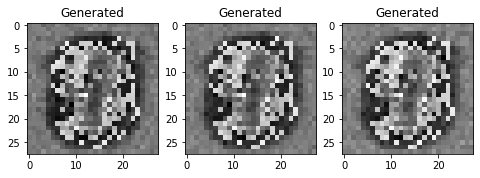

235it [00:18, 12.61it/s]


=== #Epoch: 2, Generator Loss: 0.526, Discriminator Real Loss: 0.124, Fake Loss: 3.786


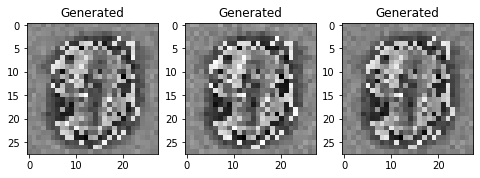

235it [00:18, 12.42it/s]


=== #Epoch: 3, Generator Loss: 0.526, Discriminator Real Loss: 0.123, Fake Loss: 3.786


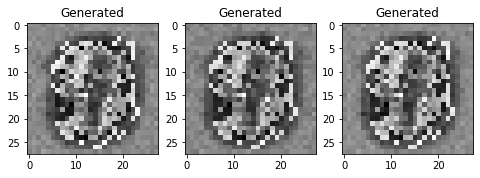

In [40]:
train(gen=generator, disc=discriminator, gen_optim=generator_optimizer, disc_optim=discriminator_optimizer, data_loader=data_loader, loss=loss, epochs=3)

In [12]:
noise = torch.randn(batch_size, channels_size, width, height).to(device)
fake_images = generator(noise)
discriminator(fake_images)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1

In [13]:
true_images = next(iter(data_loader))[0].to(device)
discriminator(true_images)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

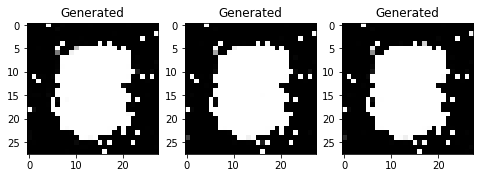

In [14]:


plot_images(images=[fake_images[0, 0].cpu().detach().numpy(), fake_images[1, 0].cpu().detach().numpy(), fake_images[2, 0].cpu().detach().numpy()])


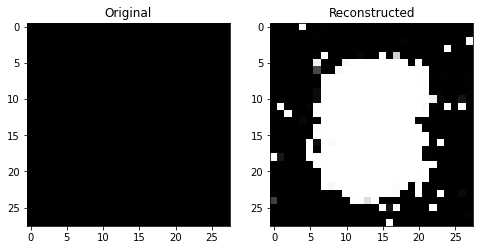

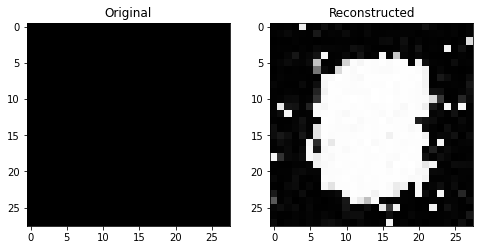

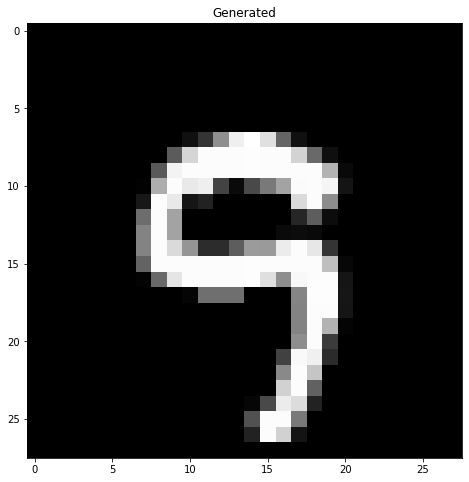

In [15]:
z = torch.randn(batch_size, channels_size, width, height).to(device)
z = torch.ones(batch_size, channels_size, width, height).to(device)
res = generator(z)
org_img = z[0][0]
org_img = org_img.cpu()
res_img = res[0][0].cpu()
res_img = res_img.detach().numpy()
plot_images(images=[org_img, res_img])

z = torch.zeros(batch_size, channels_size, width, height).to(device)
res = generator(z)
org_img = z[0][0]
org_img = org_img.cpu()
res_img = res[0][0].cpu()
res_img = res_img.detach().numpy()
plot_images(images=[org_img, res_img])



disc_res = discriminator(res)
loss = loss(disc_res, torch.ones(batch_size,1).to(device))

batch_x, batch_y = next(iter(data_loader))
plot_images([batch_x[255][0]])

In [16]:
z = torch.randn(batch_size, channels_size, width, height).to(device)
res = generator(z)
disc_res_fake = discriminator(res)
disc_res_noise = discriminator(z)